In [8]:
import os
os.environ['TEANO_FLAGS'] = 'device=gpu0'
import sys
proj_path = '/home/matsui-k/projects/d-rcn/'
sys.path.append('/home/matsui-k/projects/d-rcn')
import time

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.set_cmap('viridis')
import scipy.io as sio

from scripts.core import TN_utils, optimizers, compling_multiorder, models_multi_order, blocks
reload(TN_utils)
reload(models_multi_order)
reload(compling_multiorder)
reload(blocks)

In [5]:
input_tensors, output_tensors = TN_utils.load_blind(input_L=8, output_L=8, folder_name='in8out8')

[(0, 1), (1, 6), (6, 15), (15, 28), (28, 45)] [(0, 1), (1, 6), (6, 15), (15, 28), (28, 45)]
(855000, 2)
(855000, 10)
(855000, 18)
(855000, 26)
(855000, 34)
(855000, 2)
(855000, 10)
(855000, 18)
(855000, 26)
(855000, 34)


In [6]:
train_input, train_output, test_input, test_output, input_coef, output_coef = TN_utils.pre_blind(input_tensors, output_tensors, N=1000)

In [7]:
print [ti.shape for ti in train_input]
print [to.shape for to in train_output]
print [ti.shape for ti in test_input]

[(800, 2, 1), (800, 10, 1), (800, 18, 1), (800, 26, 1), (800, 34, 1)]
[(800, 2), (800, 10), (800, 18), (800, 26), (800, 34)]
[(199, 2, 1), (199, 10, 1), (199, 18, 1), (199, 26, 1), (199, 34, 1)]


In [8]:
nn = models_multi_order.Rcn2layer_multioreder(
        j_input_list=[0, 2, 4, 6, 8], j_output=8, n_input_tensors_list=[1, 1, 1, 1, 1],
        n_hidden_tensors=10, func_key_list=['relu', 'linear'])

In [11]:
train_output[4].shape, test_output[4].shape

((800, 34), (199, 34))

In [12]:
%%time
results = compling_multiorder.compile(
        train_input, train_output[4], test_input, test_output[4],
        model=nn, make_updates=optimizers.adam)
f_train, f_training_error, f_test_error, f_output, param_list = results

[(0, 8), (2, 6), (2, 8), (4, 4), (4, 6), (4, 8), (6, 6), (6, 8), (8, 8)]
do ordinary forward

/home/matsui-k/projects/d-rcn/scripts/core/compling_multiorder.py:65: UserWarning: theano.function was asked to create a function computing outputs given certain inputs, but the provided input variable at index 8 is not part of the computational graph needed to compute the outputs: beta.
To make this warning into an error, you can pass the parameter on_unused_input='raise' to theano.function. To disable it completely, use on_unused_input='ignore'.
  on_unused_input='warn')
/home/matsui-k/projects/d-rcn/scripts/core/compling_multiorder.py:65: UserWarning: theano.function was asked to create a function computing outputs given certain inputs, but the provided input variable at index 9 is not part of the computational graph needed to compute the outputs: t.
To make this warning into an error, you can pass the parameter on_unused_input='raise' to theano.function. To disable it completely, use on_unused_input='ignore'.
  on_unused_input='warn')
INFO (theano.gof.compilelock): Refreshing lock 


[(0, 8), (2, 6), (2, 8), (4, 4), (4, 6), (4, 8), (6, 6), (6, 8), (8, 8)]
CPU times: user 3h 18min 14s, sys: 1min 54s, total: 3h 20min 8s
Wall time: 4h 35min 59s


In [13]:
batch_size = 100
N = train_input[0].shape[0]
n_batchs = N // batch_size
index_list = range(N)
index_list = np.asarray(np.random.permutation(index_list), dtype=np.int32)

N_test = test_input[0].shape[0]
test_index_list = np.asarray(range(N_test), dtype=np.int32)

n_epochs = 201
interval = 10
training_error_array = np.zeros((n_epochs // interval + 2,))
test_error_array = np.zeros((n_epochs // interval + 2,))

alpha = 0.001
beta1 = 0.9
beta2 = 0.999
eps = 10e-8
t = 0.

beta = 0.01

i_batch = 0
training_error = f_training_error(i_batch, index_list, batch_size, beta, t)[0]
training_error_array[0] = training_error
test_error = f_test_error(i_batch, test_index_list, batch_size)[0]
test_error_array[0] = test_error

start_time = time.clock()
for i_epoch in xrange(n_epochs):
    index_list = np.random.permutation(index_list)
    test_index_list = np.random.permutation(test_index_list)

    for i_batch in xrange(n_batchs):
        t = t + 1.
        f_train(i_batch, index_list, batch_size, alpha, beta1, beta2, eps, t, beta, t)
        
    if i_epoch % interval == 0:
        training_error = f_training_error(i_batch, index_list, batch_size, beta, t)[0]
        training_error_array[i_epoch // interval + 1] = training_error
        test_error = f_test_error(0, test_index_list, batch_size)[0]
        test_error_array[i_epoch // interval + 1] = test_error

        alpha = alpha * 0.95
        print i_epoch, training_error, test_error
print time.clock() - start_time

0 0.028700100258 0.0288142226636
10 0.0229439400136 0.0241334699094
20 0.0182982776314 0.0207860283554
30 0.0161106158048 0.0196140110493
40 0.0193143598735 0.0191330779344
50 0.0184604302049 0.0187101364136
60 0.019225500524 0.0192750580609
70 0.0172853339463 0.0183600094169
80 0.0170477293432 0.0185979343951
90 0.0173449032009 0.0180703643709
100 0.0184585787356 0.0185948144644
110 0.0192666593939 0.0202375426888
120 0.0195532850921 0.0187440030277
130 0.0182862374932 0.0178192518651
140 0.0178206581622 0.0186335854232
150 0.0156876482069 0.0194904766977
160 0.0174253229052 0.01839921996
170 0.0158366467804 0.0178570132703
180 0.0181847736239 0.0186783764511
190 0.0169018805027 0.0193552225828
200 0.0175161994994 0.0184870455414
949.674014


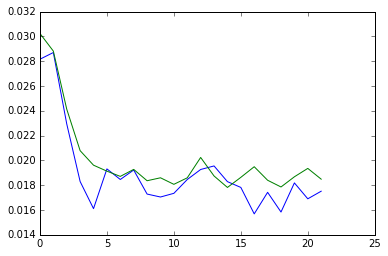

In [19]:
# まあbatch_size=100やからしょうがない
plt.plot(training_error_array)
plt.plot(test_error_array)

In [15]:
pred_train2 = TN_utils.predict_original_feature_multiorder(f_output, [tens[:, np.newaxis, :] for tens in input_tensors],
                                            np.array(input_coef)[:, np.newaxis], 34)

In [16]:
pred_train2.shape

(855000, 34)

(array([  4.72048000e+05,   2.69782000e+05,   7.06750000e+04,
          2.35000000e+04,   9.62300000e+03,   4.24700000e+03,
          2.81100000e+03,   1.72000000e+03,   5.15000000e+02,
          7.90000000e+01]),
 array([ 0.38678655,  0.55489427,  0.72300198,  0.8911097 ,  1.05921741,
         1.22732513,  1.39543284,  1.56354056,  1.73164827,  1.89975599,
         2.0678637 ]),
 <a list of 10 Patch objects>)

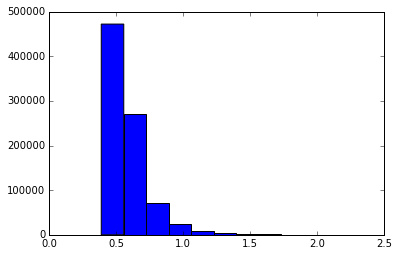

In [17]:
# L=8のhistも書くべき
plt.hist(np.linalg.norm(pred_train2, axis=1))